In [36]:
!rm -r hands_64/.ipynb_checkpoints
!ls hands_64/ -a   #to make sure that the deletion has occurred

ls: -a: No such file or directory
hands_64/:
class1


In [58]:
import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
LATENT_DIM = 64
BATCH_SIZE = 64
EPOCHS = 1000
IMAGE_SIZE = 64
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "hands_64"

# --- DATASET ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Scales to [0, 1]
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- VAE MODEL ---
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),  # 64→32
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(), # 32→16
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),# 16→8
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),  # 8→16
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),   # 16→32
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()  # 32→64
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x, mu, logvar

# --- LOSS FUNCTION ---
def vae_loss(recon_x, x, mu, logvar):
    recon = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld



In [59]:
# --- TRAINING ---
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    vae.train()
    total_loss = 0
    for batch, _ in dataloader:
        batch = batch.to(DEVICE)
        recon_batch, mu, logvar = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataset):.4f}")

    # Save sample images every few epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM).to(DEVICE)
            sample = vae.decoder(vae.fc_decode(z)).cpu()
            utils.save_image(sample, f"vae_sample_epoch{epoch+1}.png", nrow=4)



Epoch 1/1000, Loss: 605.5896
Epoch 2/1000, Loss: 221.0815
Epoch 3/1000, Loss: 183.1851
Epoch 4/1000, Loss: 152.9181
Epoch 5/1000, Loss: 138.0618
Epoch 6/1000, Loss: 127.6290
Epoch 7/1000, Loss: 120.8033
Epoch 8/1000, Loss: 113.5934
Epoch 9/1000, Loss: 106.5172
Epoch 10/1000, Loss: 101.4368
Epoch 11/1000, Loss: 96.7676
Epoch 12/1000, Loss: 93.3687
Epoch 13/1000, Loss: 90.0466
Epoch 14/1000, Loss: 86.6868
Epoch 15/1000, Loss: 84.2045
Epoch 16/1000, Loss: 82.2587
Epoch 17/1000, Loss: 80.4082
Epoch 18/1000, Loss: 78.6027
Epoch 19/1000, Loss: 76.8475
Epoch 20/1000, Loss: 75.3502
Epoch 21/1000, Loss: 73.4061
Epoch 22/1000, Loss: 72.7587
Epoch 23/1000, Loss: 71.4218
Epoch 24/1000, Loss: 70.3047
Epoch 25/1000, Loss: 68.9986
Epoch 26/1000, Loss: 68.3903
Epoch 27/1000, Loss: 67.6976
Epoch 28/1000, Loss: 66.7842
Epoch 29/1000, Loss: 65.6243
Epoch 30/1000, Loss: 65.3033
Epoch 31/1000, Loss: 64.6198
Epoch 32/1000, Loss: 63.9892
Epoch 33/1000, Loss: 63.5570
Epoch 34/1000, Loss: 62.8503
Epoch 35/1000

In [31]:
!rm -r hands_64/.ipynb_checkpoints
!ls hands_64/ -a   #to make sure that the deletion has occurred

rm: hands_64/.ipynb_checkpoints: No such file or directory
ls: -a: No such file or directory
hands_64/:
hand_frames


In [60]:
# --- INTERPOLATION EXAMPLE ---
def interpolate(z1, z2, steps=10):
    vectors = []
    for alpha in torch.linspace(0, 1, steps):
        z = (1 - alpha) * z1 + alpha * z2
        vectors.append(z)
    return torch.stack(vectors)

with torch.no_grad():
    z1 = torch.randn(LATENT_DIM).to(DEVICE)
    z2 = torch.randn(LATENT_DIM).to(DEVICE)
    z_interp = interpolate(z1, z2, steps=8).to(DEVICE)  # [8, LATENT_DIM]

    decoded = vae.fc_decode(z_interp)  # [8, 128*8*8]
    imgs = vae.decoder(decoded).cpu()  # [8, 3, 64, 64]

    utils.save_image(imgs, "vae_interpolation.png", nrow=8)

print("Training complete.")

Training complete.


In [61]:
def generate_from_random_direction(vae, scale=2.0):
    # Sample a random direction (unit vector) in latent space
    direction = torch.randn(LATENT_DIM)
    direction = direction / direction.norm()  # normalize to unit length
    z = (scale * direction).unsqueeze(0).to(DEVICE)  # shape: [1, LATENT_DIM]

    with torch.no_grad():
        decoded = vae.decoder(vae.fc_decode(z)).cpu()
    utils.save_image(decoded, "random_direction.png")

generate_from_random_direction(vae, scale=2.5)

In [65]:
def exaggerate_direction(vae, img, scale=3.0):
    vae.eval()
    img = img.to(DEVICE).unsqueeze(0)  # shape: [1, C, H, W]

    with torch.no_grad():
        _, mu, _ = vae(img)  # get mean vector
        direction = mu / mu.norm(dim=1, keepdim=True)  # normalize to unit direction
        z_exaggerated = direction * scale

        out = vae.decoder(vae.fc_decode(z_exaggerated)).cpu()
        utils.save_image(out, "exaggerated_hand_02.png")


example_img, _ = next(iter(dataloader))  # get one batch
exaggerate_direction(vae, example_img[30], scale=4.0)  # exaggerate features of that hand

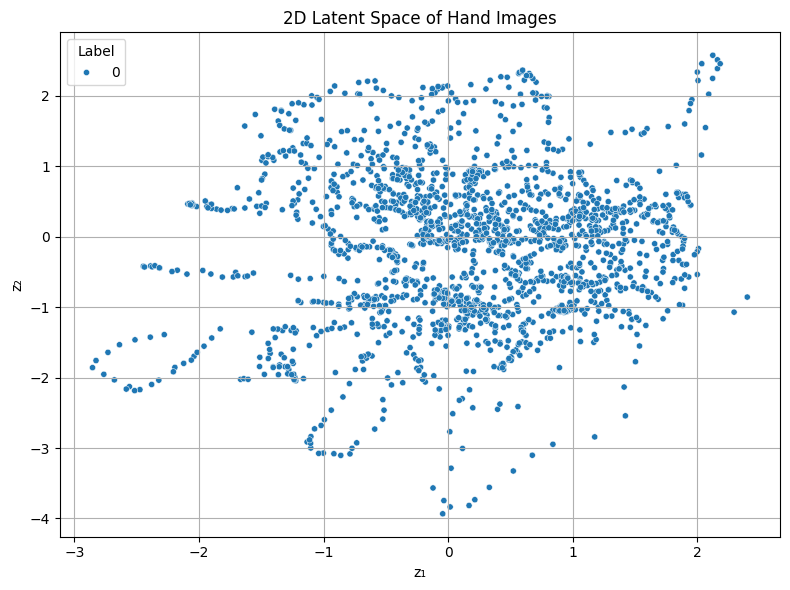

In [48]:
import matplotlib.pyplot as plt

vae.eval()
latents = []
labels = []

with torch.no_grad():
    for batch, label in dataloader:
        batch = batch.to(DEVICE)
        _, mu, _ = vae(batch)
        latents.append(mu.cpu())
        labels.append(label)

latents = torch.cat(latents)
labels = torch.cat(labels)

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=labels, palette='tab10', s=20)
plt.title("2D Latent Space of Hand Images")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.legend(title="Label", loc="best")
plt.tight_layout()
plt.savefig("latent_space_2d.png")
plt.show()

In [49]:
import numpy as np

def generate_grid(vae, range_lim=3.0, steps=20):
    """Generates a 2D grid of decoded images over latent space"""
    lin = torch.linspace(-range_lim, range_lim, steps)
    z_grid = torch.stack([torch.cartesian_prod(lin, lin)])[0].to(DEVICE)  # shape: [steps*steps, 2]
    
    with torch.no_grad():
        decoded = vae.decoder(vae.fc_decode(z_grid)).cpu()

    grid_img = utils.make_grid(decoded, nrow=steps, padding=2)
    utils.save_image(grid_img, "latent_space_grid.png")

generate_grid(vae, range_lim=3.0, steps=20)

In [63]:
import torch
import numpy as np
from torchvision.utils import save_image
from PIL import Image
import os

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

def walk_latent_space_gif(vae, start=None, direction=None, steps=30, step_size=0.5, gif_name="latent_walk_04.gif"):
    #LATENT_DIM = 2  # you must define this in your VAE model class

    if start is None:
        start = torch.zeros(LATENT_DIM).to(DEVICE)
    if direction is None:
        direction = torch.randn(LATENT_DIM).to(DEVICE)
        direction = direction / direction.norm()  # normalize

    os.makedirs("walk_frames", exist_ok=True)
    frames = []

    for i in range(steps):
        z = start + i * step_size * direction
        z = z.unsqueeze(0)  # batch size 1

        with torch.no_grad():
            x_hat = vae.decoder(vae.fc_decode(z)).cpu()
        
        frame_path = f"walk_frames/frame_{i:02d}.png"
        save_image(x_hat, frame_path)
        frames.append(Image.open(frame_path))

    # Save GIF
    frames[0].save(
        gif_name,
        save_all=True,
        append_images=frames[1:],
        duration=150,
        loop=0
    )
    print(f"GIF saved as {gif_name}")

# Example:
#direction = torch.tensor([0.0, 1.0]).to(DEVICE)
walk_latent_space_gif(vae, steps=30, step_size=1)

GIF saved as latent_walk_04.gif
